In [ ]:
# Default code in kaggle.
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, utils
from torch import nn
import albumentations as A
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2
from albumentations.pytorch import ToTensorV2
from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch import nn
import zipfile
import random
import itertools
import colorsys
from skimage.measure import find_contours
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import IPython.display
%matplotlib inline


In [ ]:
# Intall Pycocotools. 
# This library will be used for computing the evaluation metrics 
# following the COCO metric for intersection over union.
! pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Unzip data from 2018 data science bowl

In [5]:
if not os.path.exists('/kaggle/working/data'):
    os.mkdir('/kaggle/working/data')
    
zip_path = '/kaggle/input/data-science-bowl-2018/stage1_train.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/data')  

In [6]:
! unzip -q /kaggle/input/data-science-bowl-2018/stage1_test.zip -d stage1_test
! unzip -q /kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip

# Build dataset for nucleus seg data

In [7]:
# Transform for data augmentation
def get_transforms(mean,std):
            list_transforms = []
            list_transforms.extend([A.RandomRotate90(p=0.5),])
            list_transforms.extend([A.HorizontalFlip(p=0.5),])
            list_transforms.extend([A.Normalize(mean=mean, std=std, p=1),])
            list_transforms.extend([A.VerticalFlip(p=0.5),])
            
            list_trfms = Compose(list_transforms)
            return list_trfms


class Nucleus_data(Dataset):
        def __init__(self,path,transforms = None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5,0.5)          
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            # read  images and masks from the training dataset
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(256,256))
                       
            mask = self.get_mask(mask_folder, 256, 256 ).astype('uint8')
            
            augmented = self.transforms(image=img, mask=mask) # data augmentation
            img = augmented['image']
            img = img.transpose(2,0,1)
            
            mask = augmented['mask']
            mask = mask.transpose((2,0,1))
    
            # build boxes from masks, necessary for mask-RCNN
            num_objs = mask.shape[0]
            boxes = []
            for i in range(num_objs):
                pos = np.where(mask[i,:,:])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])
                
            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            masks = torch.as_tensor(mask, dtype=torch.uint8)
            img = torch.as_tensor(img, dtype=torch.float32)
            

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            return img, target

        # combine single 2D instance mask images to a 3D mask file with all objects added together
        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, len(os.listdir(mask_folder))),dtype = bool)
            i = 0
            for mask_ in os.listdir(mask_folder):
                    i += 1
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask[mask>0] = 1
                    mask[:,:,i-1] = mask_
              
            return mask

In [8]:
#loading the data
base_dir = '/kaggle/working/data/'
data2 = Nucleus_data(base_dir)

In [ ]:
print(len(data2))

In [ ]:
image, targets = data2.__getitem__(1)
print(targets['masks'].shape)

In [11]:
# Some utility functions to show images, modified from https://www.kaggle.com/code/arunmohan003/unet-starter-pytorch

# Convert instance mask to semantic mask
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.max(axis = 0)
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

# Convert tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(no_):
    images = []
    masks = []
    random_idx = np.random.choice(len(data2),no_)
    for i in random_idx:      
        image,target = data2.__getitem__(i)
        images.append(image)
        mask = target['masks']
        masks.append(mask)
    plt.figure(figsize=(12,8))
    for idx in range(0,no_):
        image = image_convert(images[idx])
        plt.subplot(2,no_,idx+1)
        plt.title('image')
        plt.imshow(image)
    for idx in range(0,no_):
        mask = mask_convert(masks[idx])
        plt.subplot(2,no_,idx+no_+1)
        plt.title('mask')
        plt.imshow(mask,cmap='gray')
    plt.show()

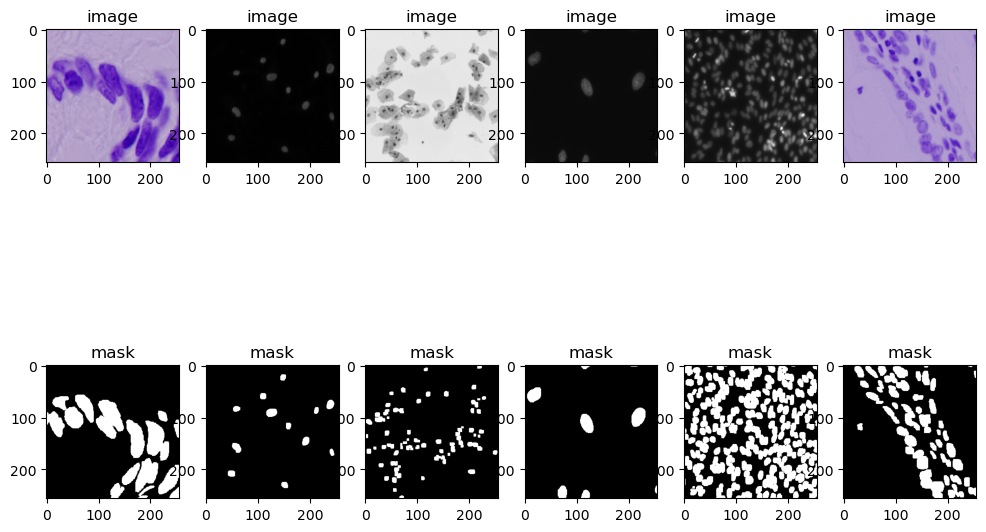

In [121]:
plot_img(6)

# Model construction

In [13]:
# Define the MASK-RCNN model, borrowed from Pytorch MaskRCNN tutorial,
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [14]:
# detection contains utils codes from Pytorch Mask-RCNN
import sys
sys.path.append('/kaggle/input/detection-codes/detection')

Run a simple test based on small data

In [ ]:
import utils
model = get_model_instance_segmentation(num_classes = 2)
data_loader = torch.utils.data.DataLoader(
    data2, batch_size=2, shuffle=True, num_workers=0,collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [15]:
# Build the dataloaders

import utils
# split the training and validation dataset to around 0.85 train and 0.15 val
trainset, valset = random_split(data2, [580, 90])

# build train dataloader
train_loader = torch.utils.data.DataLoader(
        dataset=trainset, batch_size=6, shuffle = True, num_workers = 0,
        collate_fn=utils.collate_fn)

# build validation dataloader
val_loader = torch.utils.data.DataLoader(
        dataset=valset, batch_size=6, shuffle = False, num_workers = 0, 
        collate_fn=utils.collate_fn)

In [ ]:
# Construct the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# our dataset has two classes only - background and nucleus
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

In [ ]:
# Can be used to freeze parameters if necessary
# model.backbone.requires_grad_(False)

# Training

In [43]:
# construct an optimizer
from torch.optim.lr_scheduler import StepLR

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0015,
                            momentum=0.9, weight_decay=0.0001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 10 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

In [138]:
# Construct evaluation metrics
from skimage.morphology import label

# dice score metric
def dice(im1, im2):
    im1[im1 >= 0.5] = 1
    im1[im1 < 0.5 ] = 0 #im1 is the pred image
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

# Precision helper function, modified from https://www.kaggle.com/code/wcukierski/example-metric-implementation
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

# Percision at different iou threshold metric (standard)
# return both percison and f1 score at different iou threshold
def percision_iou_cal(y_pred_in,labels_in):
    labels = label(labels_in > 0.5)
    y_pred = label(y_pred_in > 0.55)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))
  
    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Loop over IoU thresholds
    prec = []
    f1_scores =[]
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        f1 = 2*tp/(2*tp + fp + fn)
        prec.append(p)
        f1_scores.append(f1)
    return prec,f1_scores

In [19]:
!mkdir checkpoints

In [44]:
# Train function, borrowed from Pytorch tutorial, https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from engine import train_one_epoch, evaluate

def train(model, optimizer, train_loader, val_loader, device, num_epochs = 2):
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations 
        # (default method for mask-RCNN in pytorch)
        matric_logger_train = train_one_epoch(model, optimizer, 
                                              train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the val dataset (default in pytorch mask-RCNN)
        evaluator  =  evaluate(model, val_loader, device=device)
        # create checkpoint variable and add important data
        torch.save({ 
            'epoch': epoch+10, 
            'model_state_dict': model.state_dict(),  
            'loss': matric_logger_train.meters['loss'] }, 
            'checkpoints/' + '%s_%s.pth' % (str(epoch).zfill(5),epoch))
    return model

In [ ]:
model = train(model,optimizer,train_loader,val_loader,device,num_epochs = 20)

In [ ]:
# Download checkpoint file if necessary.
from IPython.display import FileLink
FileLink(r'checkpoints/00003_13.pth')

In [ ]:
# Load checkpoint
checkpoint_best = torch.load('checkpoints/00003_13.pth')
model.load_state_dict(checkpoint_best['model_state_dict'])

# Visualize performance in validation dataset

In [146]:
# function to convert mask to semantic mask for visualization
def mask_flat(mask):
    mask = mask.cpu().numpy()
    mask = mask.max(axis = 0)
    return mask

# function to convert predicted mask to semantic mask for visualization
def pred_mask_flat(prediction):
    pred_mask = prediction[0]['masks']
    pred_mask = torch.reshape(pred_mask,(pred_mask.shape[0],pred_mask.shape[2],pred_mask.shape[3]))
    pred_mask = pred_mask.cpu().numpy()
    pred_mask = pred_mask.max(axis = 0)
    pred_mask[pred_mask>0.5] = 1
    pred_mask[pred_mask<0.5] = 0
    return pred_mask

# function to convert mask/predicted mask to instance masks (2D) for visualization
def mask_to_instance(mask):
    mask = mask.cpu().numpy()
    n = mask.shape[0]
    masks = np.zeros_like(mask)
    for i in range(n): 
        m = mask[i,:,:]
        m[m > 0.5] = i+1  
        masks[i,:,:] = m
    masks = masks.max(axis = 0)
    return masks

In [147]:
# pick one image from the test set
img, targets = valset[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

0.8433409515894452
[0.8181818181818182, 0.8181818181818182, 0.7857142857142857, 0.7543859649122807, 0.7543859649122807, 0.6949152542372882, 0.4925373134328358, 0.19047619047619047, 0.05263157894736842, 0.0]
[0.9, 0.9, 0.88, 0.86, 0.86, 0.82, 0.66, 0.32, 0.1, 0.0]


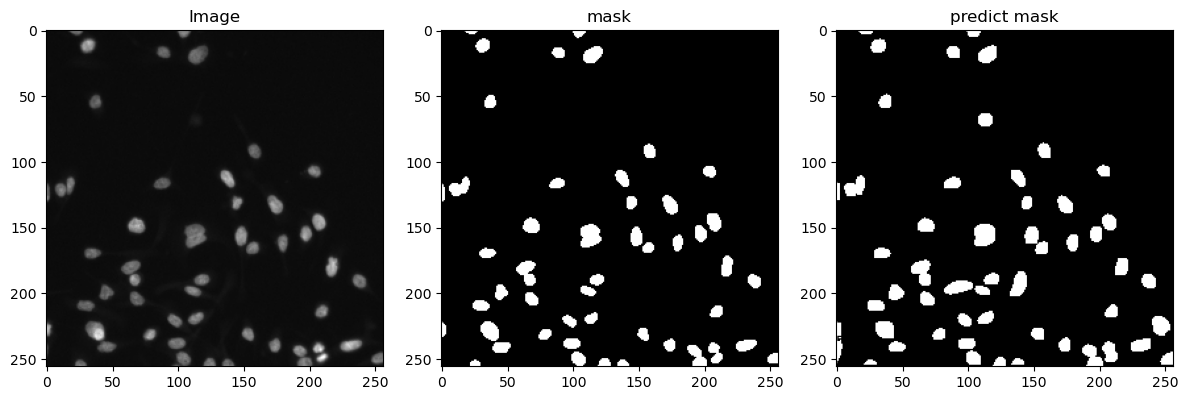

In [148]:
img = image_convert(img)
mask = targets['masks']
mask = mask_flat(mask)
pred_mask = pred_mask_flat(prediction)

dice_score = dice(pred_mask,mask)
per_iou, f1_iou = percision_iou_cal(pred_mask,mask)
print(dice_score)
print(per_iou)
print(f1_iou)

plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 3, 1)
plt.title('Image')
plt.imshow(img, cmap = 'gray')

plt.subplot(1, 3, 2)
plt.title('mask')
plt.imshow(mask,cmap = 'gray')

plt.subplot(1, 3, 3)
plt.title('predict mask')
plt.imshow(pred_mask, cmap = 'gray')

plt.tight_layout()
plt.show()

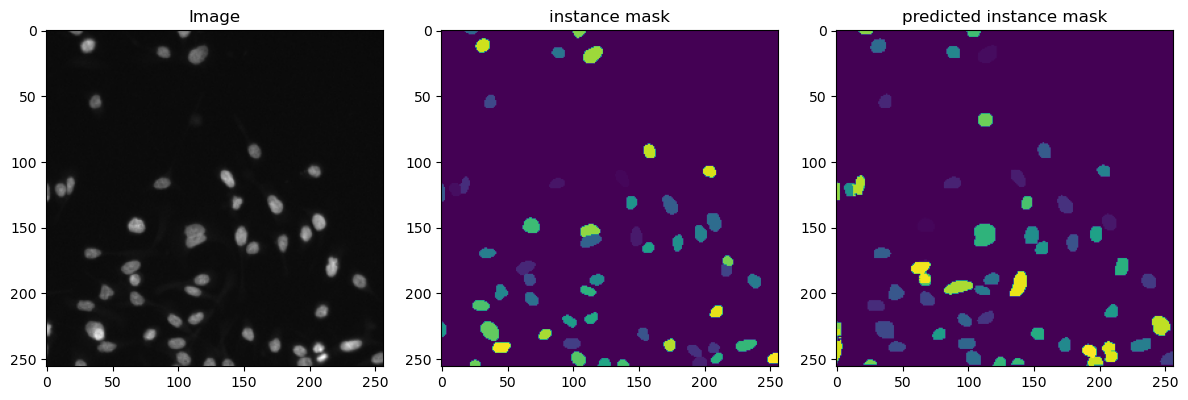

In [149]:
mask = targets['masks']
mask = mask_to_instance(mask)
pred_mask = prediction[0]['masks']
pred_mask = torch.reshape(pred_mask,(pred_mask.shape[0],pred_mask.shape[2],pred_mask.shape[3]))
pred_mask = mask_to_instance(pred_mask)

plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 3, 1)
plt.title('Image')
plt.imshow(img, cmap = 'gray')

plt.subplot(1, 3, 2)
plt.title('instance mask')
plt.imshow(mask)

plt.subplot(1, 3, 3)
plt.title('predicted instance mask')
plt.imshow(pred_mask)

plt.tight_layout()
plt.show()

# Build Test Dataset (the masks are made in a .csv file with pixel embedding instead of images, different from training data)

In [99]:
# Read mask.csv file
df=pd.read_csv('/kaggle/working/stage1_solution.csv')
df.head()

,ImageId,EncodedPixels,Height,Width,Usage
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31632 6 31886 10 32139 14 32394 15 32649 17 32...,256,256,Public
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50280 7 50534 10 50788 13 51043 14 51298 16 51...,256,256,Public
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10892 5 11146 9 11401 10 11656 11 11911 13 121...,256,256,Public
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 8 45359 10 45614 12 45869 14 46124 15 46...,256,256,Public
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,38564 4 38819 6 39074 8 39327 11 39582 12 3983...,256,256,Public


In [100]:
# Convert .csv mask with only pixel encoding to mask image
def read_image_masks(df, image_id, plot=False):
    image = cv2.imread('/kaggle/working/stage1_test/' + image_id + '/images/' + image_id + '.png')
    shape = image.shape[:2]
    masks=[]
    
    for rle in df[df.ImageId == image_id].EncodedPixels:
        try:
            decoded_result = rle_decode(rle, shape)
            masks.append(decoded_result)
        except Exception as e:
            print(e)
            print(image_id)
            print('---')
    masks = np.stack(masks, axis=-1)
    return image, masks

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[1]*shape[0], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0])).T

In [101]:
# Build testdata
def build_testdata(df):
    test_set = []
    test_mask = []
    for image_id in df.ImageId.unique()[0:len(df.ImageId.unique())]:
        img,masks=read_image_masks(df,image_id)
        #masks = transform.resize(masks,(256,256))
        #img = transform.resize(img,(256,256))
        transforms = A.Compose([
        A.Normalize(mean = 0.5, std = 0.5, p=1),
        ])
        transformed = transforms(image=img, mask=masks)
        img = transformed['image']
        mask = transformed['mask']
       
        img = img.transpose(2,0,1) # format of C x W x H
        masks = masks.transpose((2,0,1)) # format of C x W x H
        # put everything to tensor
        img = torch.as_tensor(img, dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        test_set.append(img)
        test_mask.append(masks)
    return test_set,test_mask   

In [102]:
test_set, test_mask = build_testdata(df)

# Test performance evaluation

In [103]:
def prediction(test_data,model):
    test_pred = []
    for i in range(len(test_data)):
        img = test_data[i]
        model.eval()
        with torch.no_grad():
            prediction = model([img.to(device)])
            pred_mask = prediction[0]['masks']
            # the predicted mask is of shape [object,classes,W,H], need to be reshaped
            pred_mask =  torch.reshape(pred_mask,(pred_mask.shape[0],pred_mask.shape[2],pred_mask.shape[3]))
            test_pred.append(pred_mask)
    return test_pred

In [104]:
test_pred = prediction(test_set,model)

In [105]:
# convert instance mask to semantic mask to evaluate performances
def mask_to_semantic(test_mask):
    test_mask_semantic = []
    for i in range(len(test_mask)):
        mask = test_mask[i]
        mask = mask.cpu().numpy()
        mask = mask.max(axis = 0)
        test_mask_semantic.append(mask)
    return test_mask_semantic        

In [106]:
test_pred_semantic = mask_to_semantic(test_pred) # predicted semantic mask
test_mask_semantic = mask_to_semantic(test_mask) # true semantic mask

In [107]:
# Function to calculate metric on testing data 
#(include dice score, percison at different iou, f1_score at different iou)
def metric_score(y_pred, y):
    percision_iou_scores = []
    dice_scores = []
    f1_scores =[]
    for i in range(len(y_pred)):
        pred_mask = y_pred[i]
        mask = y[i]
        percision_iou,f1 = percision_iou_cal(pred_mask,mask)
        dice_s =  dice(pred_mask,mask)
        percision_iou_scores.append(percision_iou)
        dice_scores.append(dice_s)
        f1_scores.append(f1)
    percision_iou_scores = np.array(percision_iou_scores)
    dice_scores = np.array(dice_scores)
    f1_scores = np.array(f1_scores)
    
    return percision_iou_scores, dice_scores, f1_scores
        

In [141]:
# Calculate performance metric in testing dataset
per_iou_scores,dice_scores,f1_scores = metric_score(test_pred_semantic,test_mask_semantic)

In [142]:
# Calculate mean metric
per_iou_scores_m = np.mean(per_iou_scores, axis = 0)
dice_scores_m = np.mean(dice_scores, axis = 0)
f1_scores_m = np.mean(f1_scores, axis = 0)
print(per_iou_scores_m)
print(dice_scores_m)
print(f1_scores_m)
print(np.mean(per_iou_scores_m))

[0.60691776 0.57744035 0.55827816 0.53000441 0.4989752  0.44200108
 0.36040622 0.24475229 0.08322909 0.00118413]
0.8143641163617553
[0.72485931 0.69957292 0.68261852 0.65710689 0.628644   0.57134398
 0.48641881 0.35181863 0.13651123 0.00228076]
0.39031887118153974


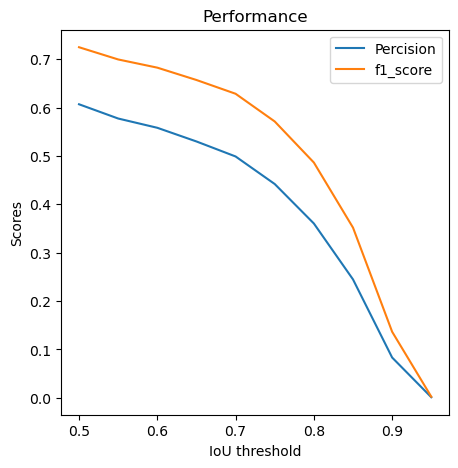

In [110]:
# Plot performance
plt.figure(figsize=(5,5))
plt.title('Performance')
x = np.arange(0.5, 1.0, 0.05)
plt.plot(x,per_iou_scores_m,label = 'Percision')
plt.plot(x,f1_scores_m,label = 'f1_score')
plt.xlabel('IoU threshold')
plt.ylabel('Scores')
plt.legend()
plt.show()

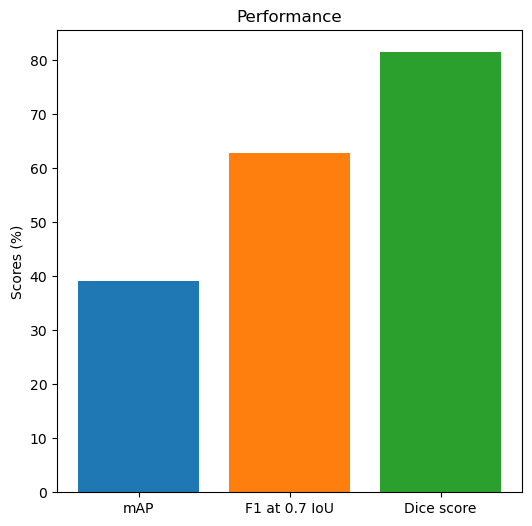

In [144]:
plt.figure(figsize=(6,6))
plt.title('Performance')
plt.bar(0, np.mean(per_iou_scores_m)*100)
plt.bar(1, f1_scores_m[4]*100)
plt.bar(2, dice_scores_m*100)
plt.ylabel('Scores (%)')
plt.xticks([0,1,2],['mAP', 'F1 at 0.7 IoU','Dice score'])
plt.show()

In [88]:
# Utility functions to better visualize the results
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_instances_mask(image, masks, figsize=(10, 10), ax=None, title = 'Ground truth'):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = masks.shape[2]
    #print (masks.shape)

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    #ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.show()
    
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [89]:
# Extension of utlity functions for visualizing the results
def plot_instance(img,masks,pred_masks):
    plt.figure(1)
    plt.figure(figsize=(5,5))
    plt.title('Image')
    plt.imshow(image_convert(img))
    plt.show()
    
    img = img.cpu().numpy()
    img = img.transpose((1,2,0))
    masks = masks.cpu().numpy()
    masks = masks.transpose((1,2,0))
    display_instances_mask(img,masks, ax=get_ax(rows=1, cols=1, size=5))
    
    pred_masks = pred_masks.cpu().numpy()
    pred_masks = pred_masks.transpose((1,2,0))
    pred_masks[pred_masks>0.5] = 1
    pred_masks[pred_masks<0.5] = 0
    display_instances_mask(img,pred_masks, ax=get_ax(rows=1, cols=1, size=5), title='predicted_mask')
    plt.show() 

def plot_instance_multiple(n,test_set,test_mask,test_pred):
    random_idx = np.random.choice(len(test_set),n)
    for idx in random_idx:
        img = test_set[idx]
        masks = test_mask[idx]
        pred_masks = test_pred[idx]
        plot_instance(img,masks,pred_masks)
    

In [ ]:
plot_instance_multiple(5,test_set,test_mask,test_pred)

# Convert prediction to .csv to sumbit

In [ ]:
# Run-length encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
# Convert image to pixel encoding
TEST_PATH = '/kaggle/working/stage1_test/'
test_ids = next(os.walk(TEST_PATH))[1]
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(test_pred_semantic[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1-maskRCNN-test.csv', index=False)